## Imports and Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pretrained_models import *
from BoxHead import *
from utils import *
from dataset import *
from tqdm import trange

In [3]:
import torchvision
import torch
import os
from torchvision.models.detection.image_list import ImageList
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.patches as patches

In [21]:
##################################################################################
#####################PLEASE CHANGE PATH OF FILE###################################

pretrained_path='/content/drive/MyDrive/UPENN/SEM 3/CIS680/HW4/checkpoint680.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone, rpn = pretrained_models_680(pretrained_path)

##################################################################################
#####################PLEASE CHANGE PATH OF FILE###################################

imgs_path   = '/content/drive/MyDrive/UPENN/SEM 3/CIS680/HW3/hw3_mycocodata_img_comp_zlib.h5'
masks_path  = '/content/drive/MyDrive/UPENN/SEM 3/CIS680/HW3/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "/content/drive/MyDrive/UPENN/SEM 3/CIS680/HW3/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "/content/drive/MyDrive/UPENN/SEM 3/CIS680/HW3/hw3_mycocodata_bboxes_comp_zlib.npy"

paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

# Standard Dataloaders Initialization
full_size  = len(dataset)
train_size = int(full_size * 0.8)
test_size  = full_size - train_size

torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 4
# print("batch size:", batch_size)
train_build_loader  = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader        = train_build_loader.loader()
test_build_loader   = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader         = test_build_loader.loader()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
box_head=BoxHead()
box_head=box_head.to(device)

## Pretrained Visualization - Output of the RPN Network (Proposals)

For the proposals We have a list containing 4 tensors
Each one with shape torch.Size([20, 4])

For the features we have a list of features for each FPN level with shapes
torch.Size([4, 256, 200, 272])
torch.Size([4, 256, 100, 136])
torch.Size([4, 256, 50, 68])
torch.Size([4, 256, 25, 34])
torch.Size([4, 256, 13, 17])


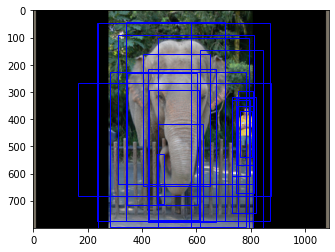

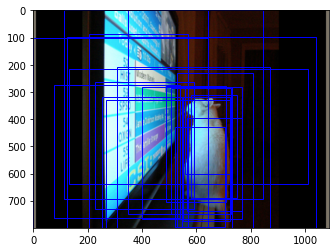

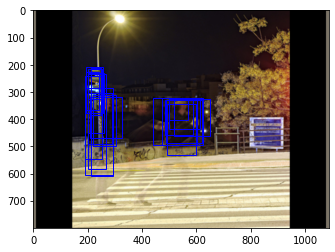

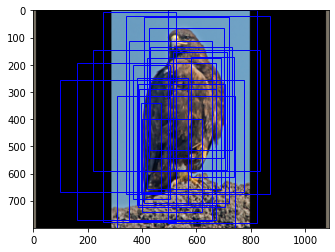

In [ ]:
# Here we keep the top 20, but during training you should keep around 200 boxes from the 1000 proposals
keep_topK=20

with torch.no_grad():
    for iter, batch in enumerate(test_loader, 0):
        images = batch['images'].to(device)
        #####################################################################################
        bboxes = batch['bbox']
        labels = batch['labels']
        #####################################################################################

        # Take the features from the backbone
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        print("For the proposals We have a list containing "+str(len(proposals))+" tensors")
        print("Each one with shape "+str(proposals[0].shape))
        print("")
        print("For the features we have a list of features for each FPN level with shapes")
        for feat in fpn_feat_list:
            print(feat.shape)


        # Visualization of the proposals
        for i in range(batch_size):
            img_squeeze = transforms.functional.normalize(images[i,:,:,:].to('cpu'),
                                                          [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                          [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
            fig,ax=plt.subplots(1,1)
            ax.imshow(img_squeeze.permute(1,2,0))


            for box in proposals[i]:
                box=box.view(-1).detach().cpu()
                rect=patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color='b')
                ax.add_patch(rect)
            plt.show()

        break

## Q1. Image plots that showcase the proposals with the no-background classes and their ground truth boxes. 

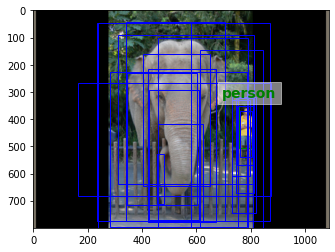

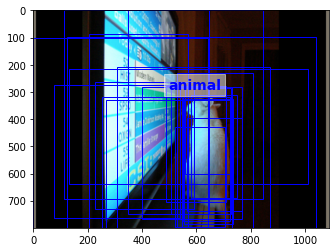

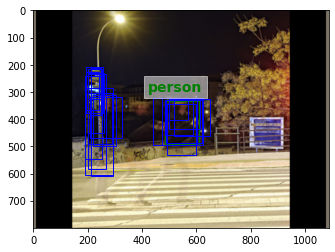

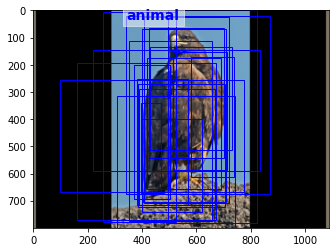

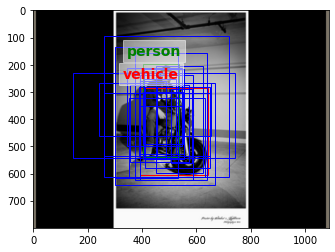

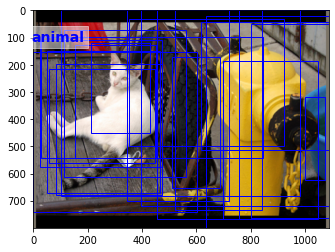

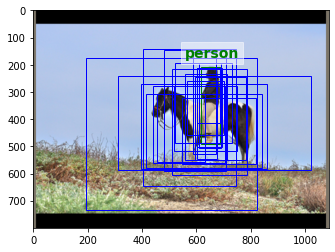

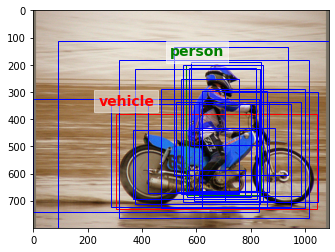

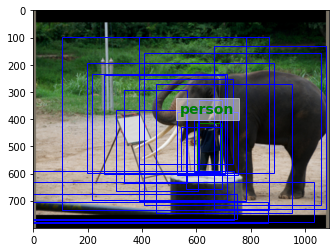

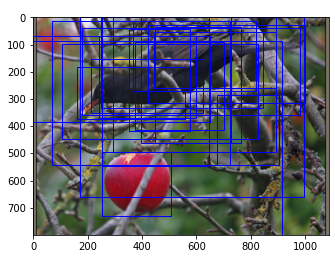

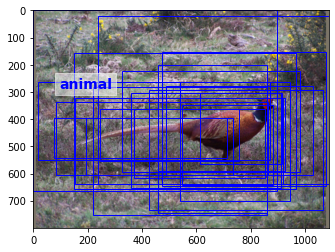

In [12]:
full_size  = len(dataset)
train_size = int(full_size * 0.8)
test_size  = full_size - train_size

torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 1
train_build_loader  = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader        = train_build_loader.loader()
test_build_loader   = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader         = test_build_loader.loader()

keep_topK   = 20
##########################################################################################################################################################################
annotations = ["vehicle", "person", "animal"]

for i, batch in enumerate(test_loader,0):
  images = batch['images'].to(device)
  #####################################################################################
  bboxes = batch['bbox']
  labels = batch['labels']

  # Take the features from the backbone
  backout = backbone(images)

  # The RPN implementation takes as first argument the following image list
  im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
  # Then we pass the image list and the backbone output through the rpn
  rpnout = rpn(im_lis, backout)

  #The final output is
  # A list of proposal tensors: list:len(bz){(keep_topK,4)}
  proposals     =[proposal[0:keep_topK,:] for proposal in rpnout[0]]
  # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
  fpn_feat_list = list(backout.values())

  feature_vectors                 = box_head.MultiScaleRoiAlign(fpn_feat_list,proposals)
  class_logits,box_pred           = box_head.forward(feature_vectors, evaluate = True)
  new_labels,regressor_target     = box_head.create_ground_truth(proposals, labels, bboxes)

  proposal_new  = torch.stack(proposals,dim=0)
  proposal_new  = proposal_new.reshape((-1, proposal_new.shape[2])).to(device)

  img_squeeze = transforms.functional.normalize(images[0].to('cpu'),
                                                [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
  fig,ax=plt.subplots(1,1)
  ax.imshow(img_squeeze.permute(1,2,0))
  
  for bboxes_list, labels_list in zip(bboxes, labels):
    for idx in range(len(bboxes_list)):
      cmap = ""
      col = ''
      if labels_list[idx] == 3:
        cmap = "jet"
        col = 'b'
      elif labels_list[idx] == 2:
        col = 'g'
        cmap = "ocean"
      elif labels_list[idx] == 1:
        col = 'r'
        cmap = "prism"

      rect = patches.Rectangle((bboxes_list[idx][0],bboxes_list[idx][1]),bboxes_list[idx][2]-bboxes_list[idx][0],bboxes_list[idx][3]-bboxes_list[idx][1],fill=False,color=col)
      ax.add_patch(rect)
      ax.annotate(annotations[labels_list[idx] - 1], (bboxes_list[idx][0] + 40, bboxes_list[idx][1] - 50), color=col, weight='bold', fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,edgecolor="white"))

  for box in proposals[0]:
      box=box.view(-1).detach().cpu()
      rect=patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color='b')
      ax.add_patch(rect)
  plt.show()
  
  if i == 10:
    break

## Q2. Training and Validation curves that show the total loss, the loss of the classifier and the loss of the regressor of the Box Head.

### Network Training

In [ ]:
box_head      = BoxHead().to(device)
# opt           = torch.optim.SGD(box_head.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)
opt = torch.optim.Adam(box_head.parameters(), lr=0.0001)

# opt             = torch.optim.SGD(box_head.parameters(),lr = 0.002,weight_decay=1.0e-4,momentum=0.90)
# scheduler       = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[25,35], gamma=0.20)
epochs = 30

In [ ]:
keep_topK     = 200

train_loss       = []
train_loss_class = []
train_loss_regr  = []

test_loss       = []
test_loss_class = []
test_loss_regr  = []

t = trange(epochs, desc='Dataset', leave=True)
for epoch in t:
# for epoch in range(10):
    train_l  = 0
    train_lc = 0
    train_lr = 0
    
    # print("Epoch {}".format(epoch))plt.plot(train_loss)
    box_head.train(True)
    for iter, batch in enumerate(train_loader):
        opt.zero_grad()
        images    = batch['images'].to(device)
        labels    = batch['labels']
        bboxes    = batch['bbox']

        # Take the features from the backbone
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        #####################################################################################
        new_labels,regressor_target  = box_head.create_ground_truth(proposals,labels, bboxes)
        feature_vectors              = box_head.MultiScaleRoiAlign(fpn_feat_list,  proposals)      
        class_logits, box_preds      = box_head.forward(feature_vectors.detach())
        loss, loss_c, loss_r         = box_head.compute_loss(class_logits, box_preds, new_labels, regressor_target, l = 0.2, effective_batch=150)
        
        train_l  += loss
        train_lc += loss_c
        train_lr += loss_r

        loss.backward()
        opt.step()
        box_head.train(False)   
        # print(loss, loss_c, loss_r )

        del feature_vectors, new_labels, regressor_target, class_logits, box_preds, loss, loss_c, loss_r
        del images, labels, bboxes, proposals, fpn_feat_list, im_lis, rpnout, backout

    train_loss      .append(train_l.cpu().item() / len(train_loader))
    train_loss_class.append(train_lc.cpu().item()/ len(train_loader))
    train_loss_regr .append(train_lr.cpu().item()/ len(train_loader))

    # print("Loss: {}, Class_loss : {}, Reg_loss:{}".format(train_loss[epoch],train_loss_class[epoch],train_loss_regr[epoch]))
    
    #####################################################################################
    ##############################TEST CASE #############################################
    #####################################################################################

    test_l = 0
    test_lc = 0
    test_lr = 0

    box_head.train(False)
    box_head.eval()

    for i, batch in enumerate(test_loader):
        images = batch['images']
        bboxes = batch['bbox']
        labels = batch['labels']
        #####################################################################################
        with torch.no_grad():
          # Take the features from the backbone
          backout = backbone(images.to(device))

          # The RPN implementation takes as first argument the following image list
          im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
          # Then we pass the image list and the backbone output through the rpn
          rpnout = rpn(im_lis, backout)

          #The final output is
          # A list of proposal tensors: list:len(bz){(keep_topK,4)}
          proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
          # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
          fpn_feat_list= list(backout.values())

          new_labels,regressor_target  = box_head.create_ground_truth(proposals,labels, bboxes)
          feature_vectors              = box_head.MultiScaleRoiAlign(fpn_feat_list,  proposals)
          class_logits,box_preds       = box_head.forward(feature_vectors)
          loss, loss_c, loss_r = box_head.compute_loss(class_logits, box_preds, new_labels, regressor_target, l = 0.2, effective_batch=150)
        
        test_l  += loss
        test_lc += loss_c
        test_lr += loss_r

        del feature_vectors, new_labels, regressor_target, class_logits, box_preds, loss, loss_c, loss_r
        del images, labels, bboxes, proposals, fpn_feat_list, im_lis, rpnout, backout

    test_loss      .append(test_l.cpu().item() / len(test_loader))
    test_loss_class.append(test_lc.cpu().item()/ len(test_loader))
    test_loss_regr .append(test_lr.cpu().item()/ len(test_loader))

    # print("Test: Loss: {}".format(test_loss[epoch]))
    
    if(epoch%3==0):
        torch.save(box_head.state_dict(), "./model_1_{}.pth".format(epoch))

    t.set_description("Epoch: {}, Train_Loss: {}, Test_loss : {}".format(epoch, train_loss[epoch],test_loss[epoch]), refresh=True)

torch.save(box_head.state_dict(), './model_1.pth')

Epoch: 29, Train_Loss: 0.11619406318431093, Test_loss : 0.11454171669192431: 100%|██████████| 30/30 [4:26:31<00:00, 533.05s/it]


### Loss Curves

#### Train Loss

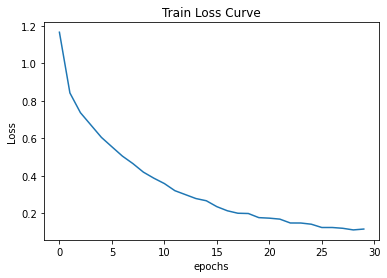

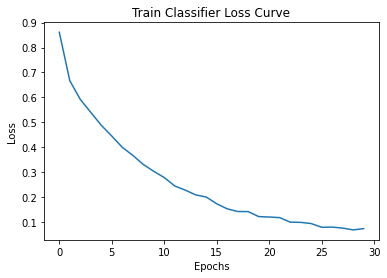

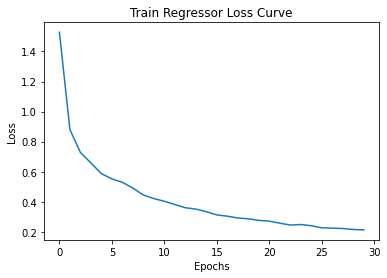

In [ ]:
plt.plot(train_loss)
plt.title('Train Loss Curve')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()
plt.plot(train_loss_class)
plt.title('Train Classifier Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.plot(train_loss_regr)
plt.title('Train Regressor Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Test Loss

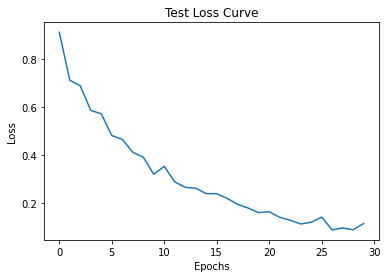

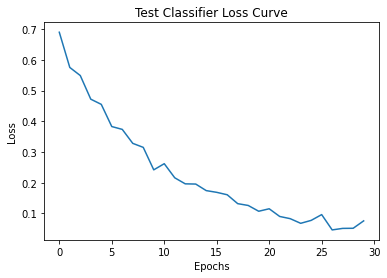

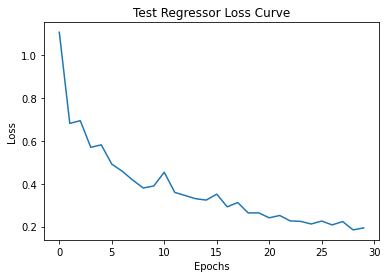

In [ ]:
plt.plot(test_loss)
plt.title('Test Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.plot(test_loss_class)
plt.title('Test Classifier Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.plot(test_loss_regr)
plt.title('Test Regressor Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Q3. Image plots that contain the top 20 boxes produced by the Box Head for some images of the test set (Section 6.4) 

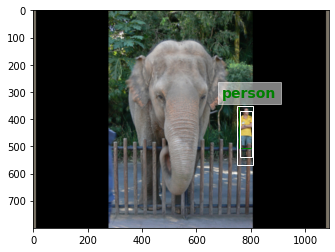

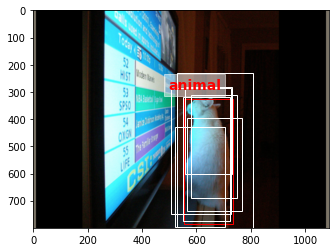

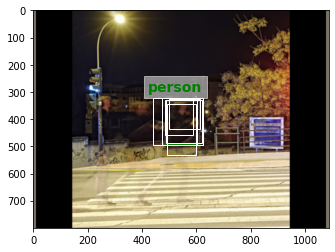

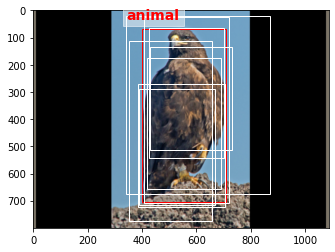

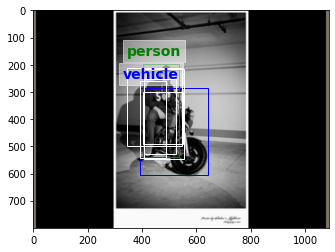

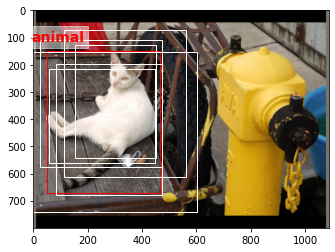

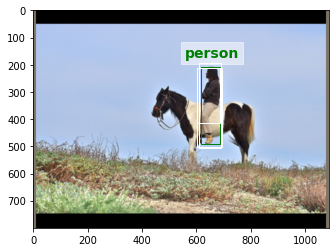

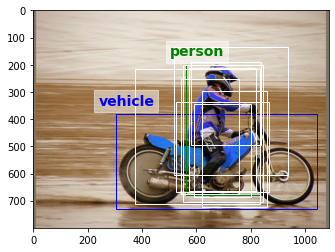

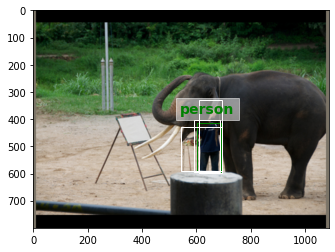

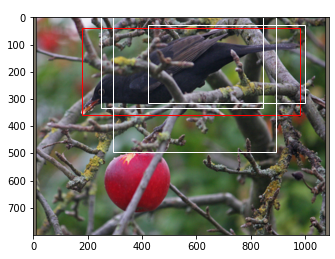

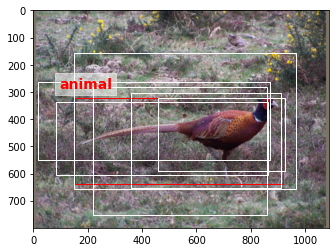

In [13]:
full_size  = len(dataset)
train_size = int(full_size * 0.8)
test_size  = full_size - train_size

torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 1
train_build_loader  = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader        = train_build_loader.loader()
test_build_loader   = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader         = test_build_loader.loader()


##########################################################################################################################################################################
annotations = ["vehicle", "person", "animal"]

for i, batch in enumerate(test_loader,0):
  images = batch['images'].to(device)
  #####################################################################################
  bboxes = batch['bbox']
  labels = batch['labels']

  # Take the features from the backbone
  backout = backbone(images)

  # The RPN implementation takes as first argument the following image list
  im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
  # Then we pass the image list and the backbone output through the rpn
  rpnout = rpn(im_lis, backout)

  #The final output is
  # A list of proposal tensors: list:len(bz){(keep_topK,4)}
  proposals     =[proposal[0:keep_topK,:] for proposal in rpnout[0]]
  # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
  fpn_feat_list = list(backout.values())

  feature_vectors                 = box_head.MultiScaleRoiAlign(fpn_feat_list,proposals)
  class_logits,box_pred           = box_head.forward(feature_vectors, evaluate = True)
  new_labels,regressor_target     = box_head.create_ground_truth(proposals, labels, bboxes)

  proposal_new  = torch.stack(proposals,dim=0)
  proposal_new  = proposal_new.reshape((-1, proposal_new.shape[2])).to(device)

  img_squeeze = transforms.functional.normalize(images[0].to('cpu'),
                                                [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
  fig,ax=plt.subplots(1,1)
  ax.imshow(img_squeeze.permute(1,2,0))
  
  for bboxes_list, labels_list in zip(bboxes, labels):
    for idx in range(len(bboxes_list)):
      cmap = ""
      col = ''
      if labels_list[idx] == 1:
        cmap = "jet"
        col = 'b'
      elif labels_list[idx] == 2:
        col = 'g'
        cmap = "ocean"
      elif labels_list[idx] == 3:
        col = 'r'
        cmap = "prism"

      rect = patches.Rectangle((bboxes_list[idx][0],bboxes_list[idx][1]),bboxes_list[idx][2]-bboxes_list[idx][0],bboxes_list[idx][3]-bboxes_list[idx][1],fill=False,color=col)
      ax.add_patch(rect)
      ax.annotate(annotations[labels_list[idx] - 1], (bboxes_list[idx][0] + 40, bboxes_list[idx][1] - 50), color=col, weight='bold', fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,edgecolor="white"))

  for box_final, labels_final in zip(proposal_new[torch.where(new_labels > 1)[0]], new_labels[torch.where(new_labels > 1)[0]]):
    box_final = box_final.cpu().detach().numpy()
    labels_final = int(labels_final.cpu().detach().numpy())

    cmap = ""
    col = ''
    if labels_final == 3:
      cmap = "jet"
      col = 'b'
    elif labels_final == 2:
      col = 'g'
      cmap = "ocean"
    elif labels_final == 1:
      col = 'r'
      cmap = "prism"
    
    rect=patches.Rectangle((box_final[0],box_final[1]),box_final[2]-box_final[0],box_final[3]-box_final[1],fill=False,color="white")
    ax.add_patch(rect)
  
  if i == 10:
    break

## Q4. Report of the APs and the mAP. More details about how you should evaluate your model will be published soon.

In [30]:
backbone, rpn = pretrained_models_680(pretrained_path)
dataset = BuildDataset(paths)

# Standard Dataloaders Initialization
full_size  = len(dataset)
train_size = int(full_size * 0.8)
test_size  = full_size - train_size

torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 4
# print("batch size:", batch_size)
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

box_head      = BoxHead().to(device)
# opt           = torch.optim.SGD(box_head.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)
# opt             = torch.optim.SGD(box_head.parameters(),lr = 0.002,weight_decay=1.0e-4,momentum=0.90)
# scheduler       = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[25,35], gamma=0.20)
# lr            = 0.0007
# opt           = torch.optim.Adam(box_head.parameters(), lr = 0.0001)
keep_topK     = 200


train_model_path="/content/model_1.pth"
checkpoint = torch.load(train_model_path)
# reload models
box_head.load_state_dict(checkpoint)

predictions_list = []
ground_truth_list = []
box_head.eval()
with torch.no_grad():

    for i, batch in enumerate(test_loader):
        images = batch['images'].to(device)
        bboxes = batch['bbox']
        labels = batch['labels']
        #####################################################################################

        # Take the features from the backbone
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        new_labels,regressor_target  = box_head.create_ground_truth(proposals,labels, bboxes)
        feature_vectors              = box_head.MultiScaleRoiAlign(fpn_feat_list,  proposals)
        # feature_vecs                 = feature_vectors.detach()

        class_logits,box_preds=box_head.forward(feature_vectors)
        
        loss, loss_c, loss_r = box_head.compute_loss(class_logits, box_preds, new_labels, regressor_target)
        
        labels_nms, scores_nms, boxes_nms = box_head.postprocess_detections_map_scores(class_logits, box_preds, proposals, conf_thresh=0.5, keep_num_preNMS=500, keep_num_postNMS=50)
        if len(boxes_nms) > 0:
            labels_nms = torch.hstack((labels_nms)).reshape(-1, 1)
            scores_nms = torch.hstack((scores_nms)).reshape(-1, 1)
            boxes_nms = torch.vstack(boxes_nms)
            
            
            predictions_tensor = torch.hstack((labels_nms, scores_nms, boxes_nms))
            predictions_list.append(predictions_tensor)

            ground_truth_tensor = torch.hstack((torch.tensor(np.hstack((labels[:]))).reshape(-1, 1), 
                                                torch.vstack(bboxes)))
            ground_truth_list.append(ground_truth_tensor)
            
    map_ = mean_average_precision(predictions_list, ground_truth_list)


    print(map_)

[0.2040015161037445, 0.1840587556362152, 0.30807074904441833]


In [31]:
avg = sum(map_)/len(map_)
print('MAP Scores: Objects: {}, Humans: {}, Animals and Birds: {}'.format(map_[0], map_[1], map_[2]))
print('Average MAP Score:',avg)

MAP Scores: Objects: 0.2040015161037445, Humans: 0.1840587556362152, Animals and Birds: 0.30807074904441833
Average MAP Score: 0.2320436735947927


## Q5. Image plots of the regressed boxes after the postprocessing.

[751.32    364.15924 810.071   546.9888 ]


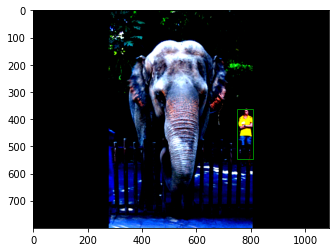

-----


[564.50964 321.43768 762.7152  778.6645 ]


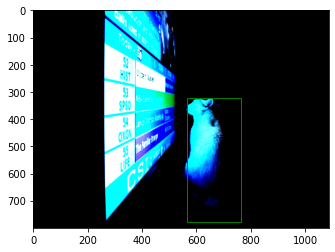

-----


[483.987   328.31973 618.34955 492.98825]


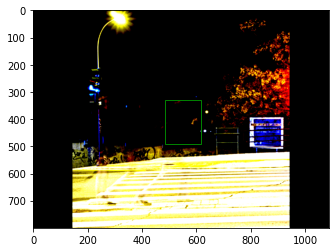

-----


[393.79712   12.045166 703.2538   713.0168  ]


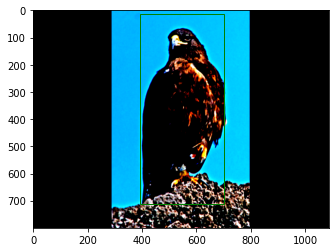

-----


[380.06186 273.78302 626.5552  612.5662 ]
[403.22086 197.6446  543.7234  528.8138 ]
[413.6238  192.71863 551.4231  543.3631 ]
[390.607   273.01685 619.38116 617.75037]


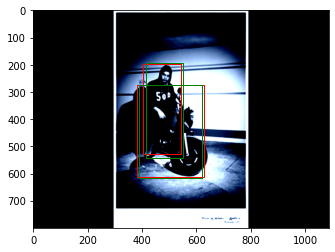

-----


[ 69.616714 163.08371  471.98798  664.8218  ]


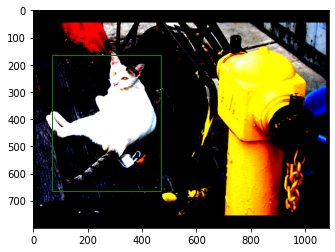

-----


[617.6182  202.94484 686.8028  489.6327 ]


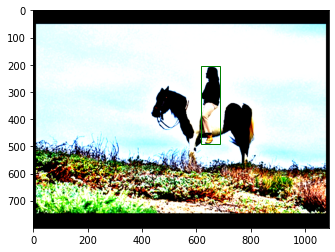

-----


[ 319.09763  402.50934 1001.7894   730.30975]
[288.4871  415.62808 991.26465 743.46643]
[588.35376 191.7417  849.9949  680.90344]


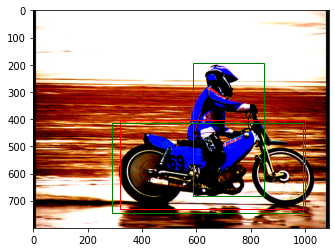

-----


[593.4734 419.9909 687.8528 594.7593]
[594.25836 410.46875 747.71    510.55566]


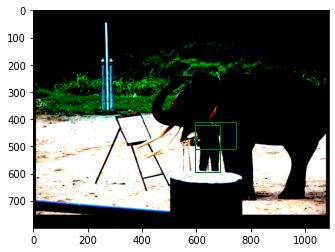

-----


[194.53323   52.860657 940.385    416.41333 ]


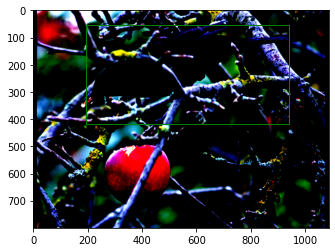

-----


[187.43118 305.252   930.4321  623.90857]


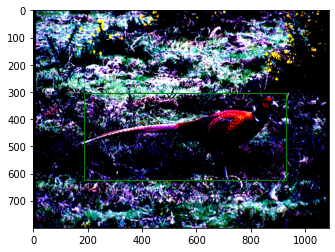

-----


In [18]:
full_size  = len(dataset)
train_size = int(full_size * 0.8)
test_size  = full_size - train_size

torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()


# Put the path were you save the given pretrained model
# pretrained_path='/content/drive/MyDrive/UPENN/SEM 3/CIS680/HW4/checkpoint680.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone, rpn = pretrained_models_680(pretrained_path)

# we will need the ImageList from torchvision
# from torchvision.models.detection.image_list import ImageList

# Load your model here. If you use different parameters for the initialization you can change the following code
# accordingly
boxHead=BoxHead()
boxHead=boxHead.to(device)
boxHead.eval()

# Put the path were you have your save network
train_model_path='/content/model_1.pth'
checkpoint = torch.load(train_model_path)
# reload models
# boxHead.load_state_dict(checkpoint['box_head_state_dict'])
boxHead.load_state_dict(checkpoint)

keep_topK=200

cpu_boxes = []
cpu_scores = []
cpu_labels = []

for i, numpy_image in enumerate(test_loader, 0):
    images = numpy_image['images'].to(device)
    bboxes = batch['bbox']
    labels = batch['labels']
    with torch.no_grad():
        # Take the features from the backbone
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())


        feature_vectors                 = boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)
        class_logits,box_pred           = boxHead.forward(feature_vectors, evaluate = True)
        new_labels,regressor_target     = box_head.create_ground_truth(proposals,labels, bboxes)
        # Do whaterver post processing you find performs best
        boxes,scores,labels             = boxHead.postprocess_detections(class_logits,box_pred,proposals,conf_thresh=0.5, keep_num_preNMS=200, keep_num_postNMS=3)
        
        fig,ax=plt.subplots(1,1)
        ax.imshow(images[0].permute(1,2,0).cpu().detach().numpy())
        for box, score, label in zip(boxes,scores,labels):
            if box is None:
                cpu_boxes.append(None)
                cpu_scores.append(None)
                cpu_labels.append(None)
            else:
                cpu_boxes.append(box.to('cpu').detach().numpy())
                cpu_scores.append(score.to('cpu').detach().numpy())
                cpu_labels.append(label.to('cpu').detach().numpy())
                # cpu_boxes.append(box)
                # cpu_scores.append(score)
                # cpu_labels.append(label)

        for kk, box_label in enumerate(zip(cpu_boxes[i], cpu_labels[i])):
            cmap = ""
            col = ''
            if int(box_label[1]) == 1:
                color = 'r'
                cmap = "prism"
            if int(box_label[1]) == 2:
                color = 'g'
                cmap = "ocean"
            if int(box_label[1]) == 3:
              cmap = "jet"
              col = 'b'
            box=box_label[0]
            print(box)
            rect=patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color=color)
            ax.add_patch(rect)
            # ax.annotate(annotations[int(box_label[1])  - 1], (box[0] + 40, box[1] - 50), color=col, weight='bold', fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,edgecolor="white"))
        plt.show()

        print('-----')
        
        if i == 10:
          break

## Post-Process Visualisation on Hold Out Images

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


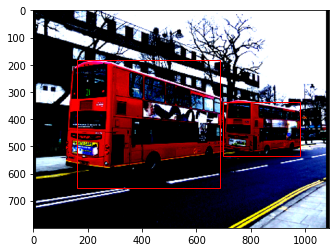

-----


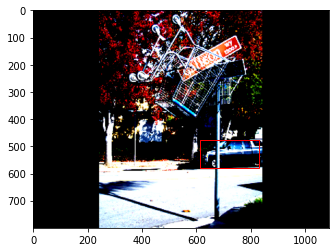

-----


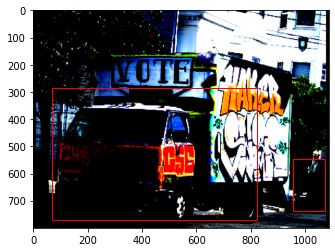

-----


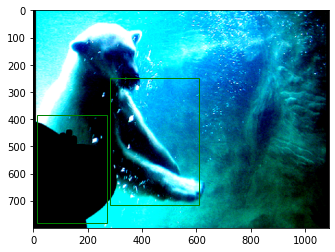

-----


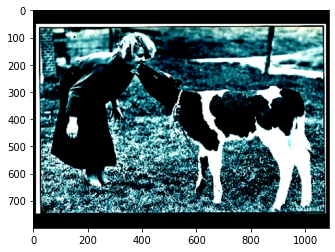

-----


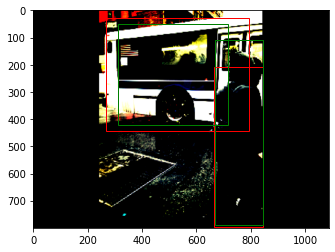

-----


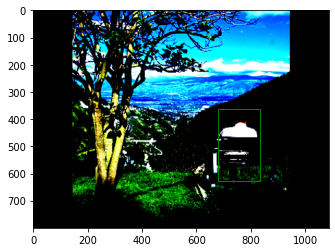

-----


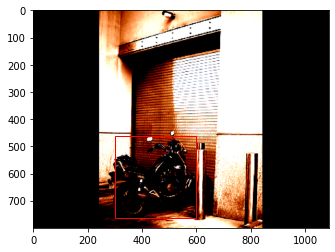

-----


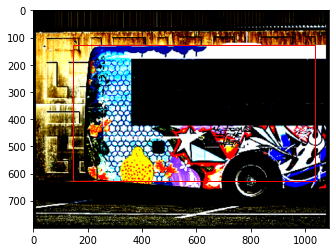

-----


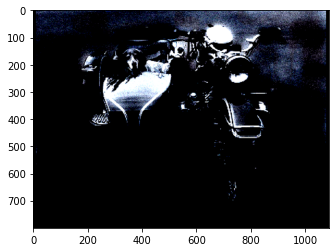

-----


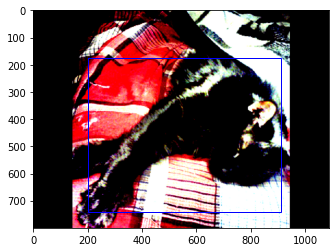

-----


In [9]:
# Put the path were you save the given pretrained model
# pretrained_path='/content/drive/MyDrive/UPENN/SEM 3/CIS680/HW4/checkpoint680.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone, rpn = pretrained_models_680(pretrained_path)

# we will need the ImageList from torchvision
# from torchvision.models.detection.image_list import ImageList

# Put the path were the given hold_out_images.npz file is save and load the images
hold_images_path='/content/drive/MyDrive/UPENN/SEM 3/CIS680/HW4/hold_out_images.npz'
test_images=np.load(hold_images_path,allow_pickle=True)['input_images']

# Load your model here. If you use different parameters for the initialization you can change the following code
# accordingly
boxHead=BoxHead()
boxHead=boxHead.to(device)
boxHead.eval()

# Put the path were you have your save network
train_model_path='/content/model_1.pth'
checkpoint = torch.load(train_model_path)
# reload models
# boxHead.load_state_dict(checkpoint['box_head_state_dict'])
boxHead.load_state_dict(checkpoint)

keep_topK=200

cpu_boxes = []
cpu_scores = []
cpu_labels = []

for i, numpy_image in enumerate(test_images, 0):
    # images = numpy_image['images'].to(device)
    images = torch.from_numpy(numpy_image).to(device)
    with torch.no_grad():
        # Take the features from the backbone
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())


        feature_vectors                 = boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)
        class_logits,box_pred           = boxHead.forward(feature_vectors, evaluate = True)
        # new_labels,regressor_target     = box_head.create_ground_truth(proposals,labels, bboxes)
        # Do whaterver post processing you find performs best
        boxes,scores,labels             = boxHead.postprocess_detections(class_logits,box_pred,proposals,conf_thresh=0.5, keep_num_preNMS=200, keep_num_postNMS=3)
        
        fig,ax=plt.subplots(1,1)
        ax.imshow(images[0].permute(1,2,0).cpu().detach().numpy())
        for box, score, label in zip(boxes,scores,labels):
            if box is None:
                cpu_boxes.append(None)
                cpu_scores.append(None)
                cpu_labels.append(None)
            else:
                cpu_boxes.append(box.to('cpu').detach().numpy())
                cpu_scores.append(score.to('cpu').detach().numpy())
                cpu_labels.append(label.to('cpu').detach().numpy())
                # cpu_boxes.append(box)
                # cpu_scores.append(score)
                # cpu_labels.append(label)

        for kk, box_label in enumerate(zip(cpu_boxes[i], cpu_labels[i])):
            if int(box_label[1]) == 1:
                color = 'r'
            if int(box_label[1]) == 2:
                color = 'g'
            if int(box_label[1]) == 3:
                color = 'b'
            box=box_label[0]
            rect=patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color=color)
            ax.add_patch(rect)
        plt.show()

        print('-----')
        
        if i == 10:
          break
